## Download repo


In [0]:
import os
import shutil
import zipfile
import urllib.request

In [0]:
REPO_ZIP_FILE = 'LinearizedNNs-master.zip'
urllib.request.urlretrieve('https://github.com/maxkvant/LinearizedNNs/archive/master.zip', REPO_ZIP_FILE)

REPO_PATH = "LinearizedNNs-master"
if os.path.exists(REPO_PATH):
    shutil.rmtree(REPO_PATH)
    
with zipfile.ZipFile(REPO_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')
    
assert os.path.exists(REPO_PATH)

## Imports

In [0]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [0]:
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from xgboost import XGBClassifier

from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import warm_up_batch_norm
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot
from from_neural_kernels import to_zca, CustomTensorDataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def Conv(in_filters, out_filters, groups=1):
    conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, groups=groups, bias=False)
    conv.weight.data *= np.sqrt(3)
    return conv  

class Normalize(nn.Module):
    def forward(self, input):
        return nn.functional.normalize(input, p=2, dim=1, eps=1e-8)  

class ReLU2(nn.Module):
    C = np.sqrt(2)

    def forward(self, input):
        return F.relu(input, inplace=True) * self.C

class ResidualConnection(nn.Module):
    def __init__(self, *layers):
        super(ResidualConnection, self).__init__()
        self.layers = nn.Sequential(*layers)
    
    def forward(self, input):
        return (input + self.layers(input)) / 2.

class Myrtle10(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256, groups=1):
        super(Myrtle10, self).__init__()
        filters = num_filters * groups

        def Activation():
          return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters),     Activation(),

            ResidualConnection(
              Conv(filters, filters, groups), Activation(),
              Conv(filters, filters, groups), Activation(),
            ),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            ResidualConnection(
              Conv(filters, filters, groups), Activation(),
              Conv(filters, filters, groups), Activation(),
            ),
            Conv(filters, filters, groups),   Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            ResidualConnection(
              Conv(filters, filters, groups), Activation(),
              Conv(filters, filters, groups), Activation(),
            ),
            Conv(filters, filters, groups),   Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [0]:
class Myrtle5(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256, groups=1):
        super(Myrtle5, self).__init__()
        filters = num_filters * groups

        def Activation():
          return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters),   Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [0]:
class Myrtle7(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256, groups=1):
        super(Myrtle7, self).__init__()
        filters = num_filters * groups

        def Activation():
          return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters),   Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            

            Conv(filters, filters, groups), Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters, filters, groups), Activation(),
            Conv(filters, filters, groups), Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            
            Normalize(),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [0]:
def f(*argv):
  print(list(argv))
f(1, 3, 5)

[1, 3, 5]


## Cifar10

In [0]:
def get_cifar_zca():
  trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
  testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

  X_train = np.asarray(trainset.data).astype(np.float64)
  y_train = np.asarray(trainset.targets)
  X_test  = np.asarray(testset.data).astype(np.float64)
  y_test  = np.asarray(testset.targets)

  (X_train, X_test), global_ZCA = to_zca(X_train, X_test)

  X_train = np.transpose(X_train, (0,3,1,2))
  X_test  = np.transpose(X_test,  (0,3,1,2))

  return X_train, y_train, X_test, y_test

In [0]:
%%time

X_train, y_train, X_test, y_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 2min 5s, sys: 10 s, total: 2min 15s
Wall time: 1min 16s


In [0]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform='all')
cifar_test  = CustomTensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long), transform=None)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=128, shuffle=True)

device

device(type='cuda', index=0)

0.049137328

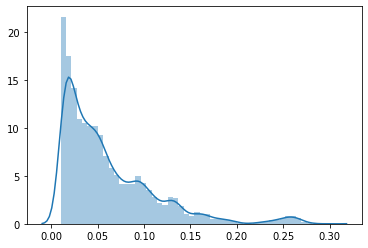

In [0]:
model = Myrtle10(num_filters=128, groups=2).to(device)
for batch_id, (X, y) in enumerate(train_loader):
  if batch_id > 20:
    break
  X, y = X.to(device), y.to(device)
  model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output[output > 1e-2].reshape(-1))

np.std(output.reshape(-1))

In [0]:
from pytorch_impl.nns.utils import print_sizes

print_sizes(Myrtle10(num_filters=64).to(device))

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
298442


298442

epoch 0/30, 0s since start


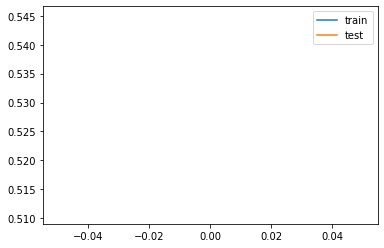

epoch 1/30, 126s since start


KeyboardInterrupt: ignored

In [0]:
model = Myrtle10(num_filters=256).to(device)

learning_rate = 0.07

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=30, learning_rate=learning_rate)

epoch 0/30, 0s since start


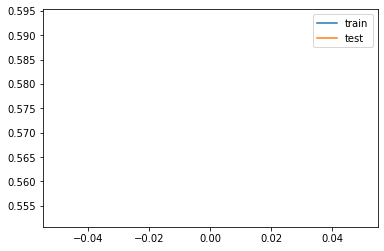

epoch 1/30, 126s since start


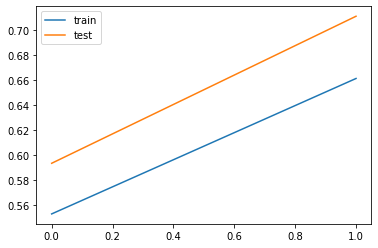

epoch 2/30, 252s since start


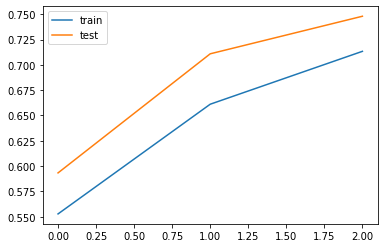

epoch 3/30, 377s since start


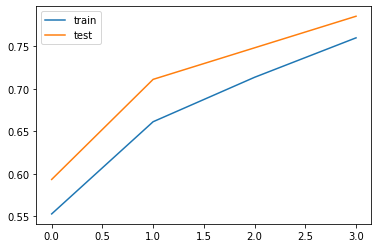

epoch 4/30, 503s since start


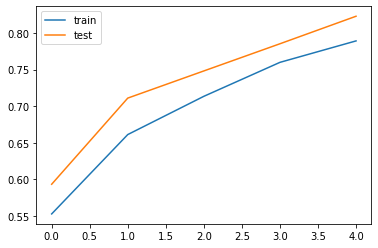

epoch 5/30, 629s since start


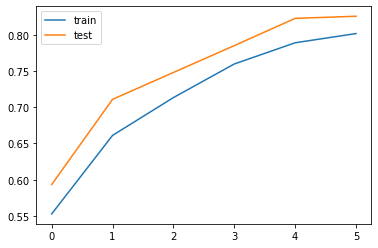

epoch 6/30, 754s since start


KeyboardInterrupt: ignored

In [0]:
model = Myrtle10(num_filters=256).to(device)

learning_rate = 0.07

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=30, learning_rate=learning_rate)

epoch 0/20, 0s since start


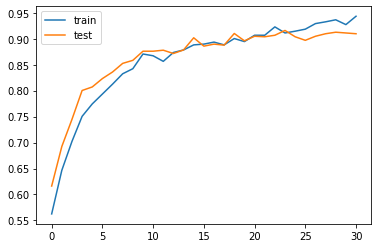

epoch 1/20, 58s since start


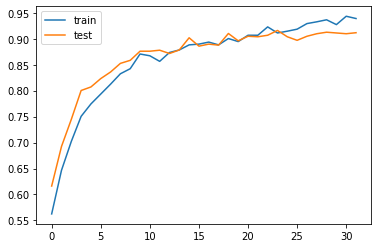

epoch 2/20, 116s since start


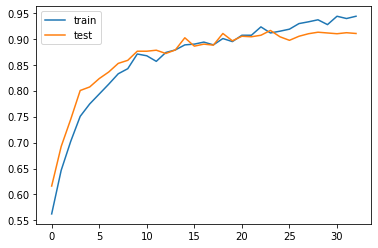

epoch 3/20, 174s since start


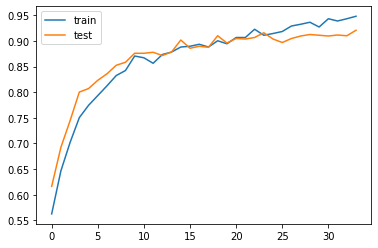

epoch 4/20, 232s since start


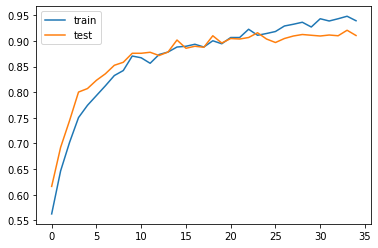

epoch 5/20, 290s since start


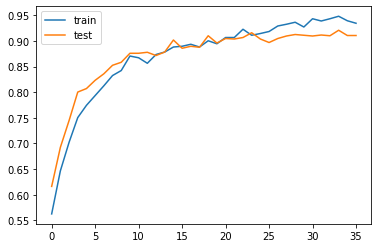

epoch 6/20, 348s since start


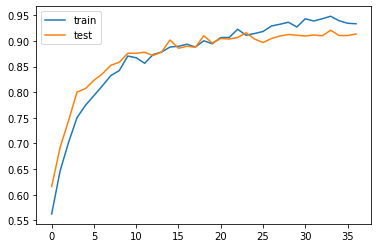

epoch 7/20, 406s since start


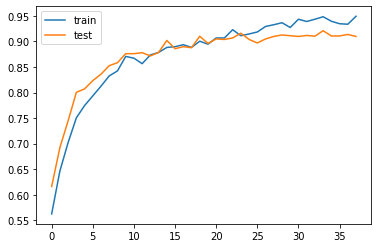

epoch 8/20, 463s since start


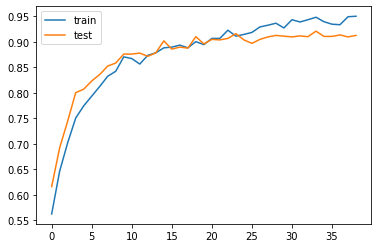

epoch 9/20, 521s since start


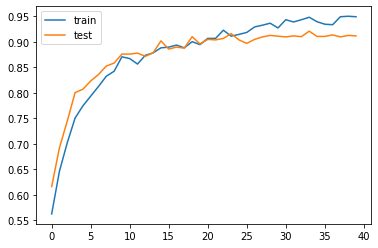

epoch 10/20, 579s since start


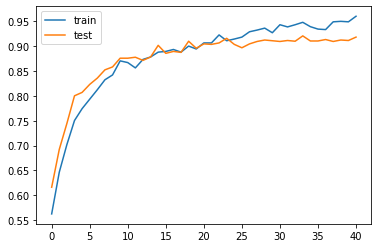

epoch 11/20, 637s since start


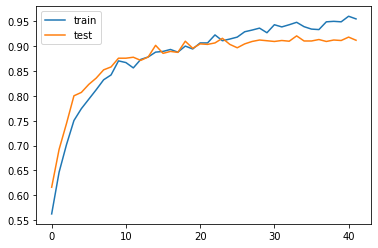

epoch 12/20, 695s since start


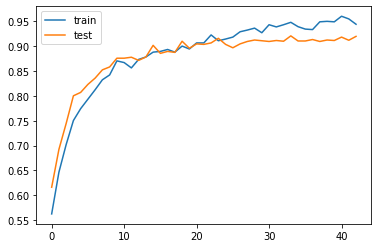

epoch 13/20, 753s since start


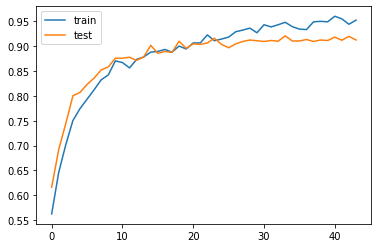

epoch 14/20, 811s since start


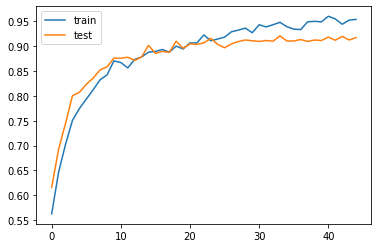

epoch 15/20, 869s since start


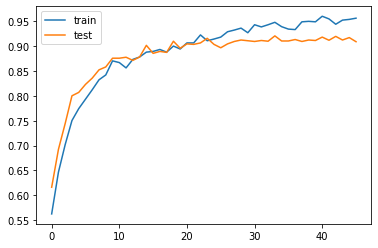

epoch 16/20, 927s since start


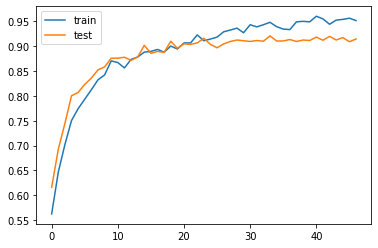

epoch 17/20, 985s since start


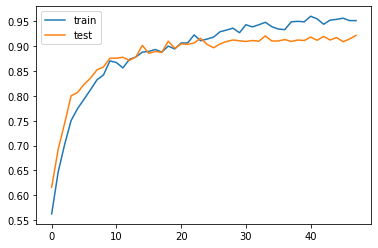

epoch 18/20, 1042s since start


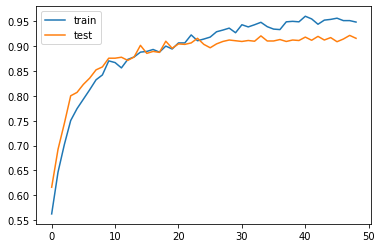

epoch 19/20, 1100s since start


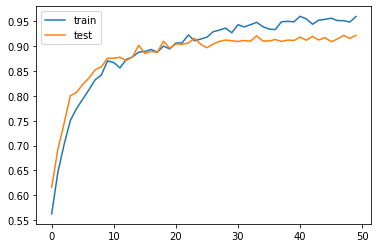

training took 1158s
test_accuracy 0.918


In [0]:
training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

In [0]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.921875

In [0]:
%%time

X_train, labels_train, X_test, labels_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 2min 9s, sys: 9.55 s, total: 2min 18s
Wall time: 1min 13s


In [0]:
N = 1280

X_train      = torch.tensor(X_train[:N]).float()
X_test       = torch.tensor(X_test[:N]).float()
labels_train = torch.tensor(labels_train[:N], dtype=torch.long)
labels_test  = torch.tensor(labels_test[:N],  dtype=torch.long)

In [0]:
labels_train[:10]

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [0]:
labels_test[:10]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [0]:
torch.manual_seed(0)
device = torch.device('cuda:0') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cuda', index=0)

In [0]:
def compute_kernels(models, X_train, X_test, device):
  with torch.no_grad():
    X_train = X_train.to(device)
    X_test  = X_test.to(device)
    
    n_train = len(X_train)
    n_test  = len(X_test)

    train_kernel = torch.zeros([n_train, n_train]).to(device)
    test_kernel  = torch.zeros([n_test,  n_train]).to(device)

    scale = np.sqrt(1. / 0.0156249953)

    m = 0
    start_time = time.time()
    for model_i, model in enumerate(models):
      if model_i & (model_i - 1) == 0:
        print(f"{model_i} models done. time {time.time() - start_time:.0f}s")
      train_features = scale * model.readout(X_train) 
      test_features  = scale * model.readout(X_test)

      m += train_features.size()[1]

      train_kernel += torch.matmul(train_features, train_features.T)
      test_kernel  += torch.matmul(test_features,  train_features.T)
    
    train_kernel /= m
    test_kernel  /= m
    
    return train_kernel, test_kernel

In [0]:
n_models = 4000

models = (Myrtle7(num_filters=32).to(device) for _ in range(n_models))

In [87]:
%%time

num_classes = 10

y_train = to_one_hot(labels_train, num_classes).to(device)
y_test  = to_one_hot(labels_test,  num_classes).to(device)

train_kernel, test_kernel = compute_kernels(models, X_train, X_test, device)

0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 1s
32 models done. time 1s
64 models done. time 2s
128 models done. time 5s
256 models done. time 9s
512 models done. time 19s
1024 models done. time 38s
2048 models done. time 76s
CPU times: user 1min 33s, sys: 54.7 s, total: 2min 27s
Wall time: 2min 27s


In [88]:
train_kernel[:5,:5]

tensor([[2.0000, 1.9919, 1.9858, 1.9942, 1.9914],
        [1.9919, 2.0000, 1.9859, 1.9930, 1.9907],
        [1.9858, 1.9859, 2.0000, 1.9847, 1.9883],
        [1.9942, 1.9930, 1.9847, 2.0000, 1.9890],
        [1.9914, 1.9907, 1.9883, 1.9890, 2.0000]], device='cuda:0')

In [89]:
test_kernel[:5,:5]

tensor([[1.9923, 1.9925, 1.9865, 1.9925, 1.9905],
        [1.9873, 1.9899, 1.9817, 1.9854, 1.9909],
        [1.9894, 1.9933, 1.9900, 1.9895, 1.9902],
        [1.9886, 1.9905, 1.9871, 1.9856, 1.9902],
        [1.9933, 1.9924, 1.9824, 1.9931, 1.9892]], device='cuda:0')

In [90]:
lr = 1e4

n = len(train_kernel)

exp_term = - lr * compute_exp_term(- lr * train_kernel, device)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(device)).float().mean()

tensor(0.6047, device='cuda:0')

In [91]:
"""
TODO experiments:
1. ZCA ✔️
2. random features ✔️
"""

'\nTODO experiments:\n1. ZCA ✔️\n2. random features ✔️\n'